In [1]:
import pandas as pd

data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Pre-processing
## Nettoyage

Pour rappel :

Notre DataSet est constitué de 12 caractéristiques, mais nous allons nous séparer de 3 caractéristiques car elles sont inutiles et ne nous donnent pas beaucoup d'informations. Par exemple, la caractéristique PassengerId et Ticket ne sont pas utiles pour la prédiction, il est donc préférable de les laisser tomber de l'ensemble de données. Et dans l'ensemble de données de la Cabin, nous avons 77% de valeurs manquantes, il n'est donc pas trivial de traiter cette caractéristique.

Dans un premier temps, nous devons récuperer les titres présent dans la variable Name grâce à une regex et les simplifier.

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

df = data.copy()

title = df.Name.str.extract('([A-Za-z]+)\.', expand=False)
df['Title'] = title

new_title = {"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}

rare_title = {}
for title in ['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
    rare_title[title] = "Rare"
    
new_title.update(rare_title)

df["Title"] = df["Title"].replace(new_title)

Ensuite nous pouvons supprimer les variables indésirables

In [3]:
df = df.drop(["PassengerId", "Ticket" , "Name", "Cabin"], axis = 1)
df = df.dropna()
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


## Encodage

Maintenant nous devons encoder les variables qualitatives pour pouvoir les utiliser dans notre modèle. Pour ce faire, nous utilisons le One-Hot encoding afin de transformer les caractéristiques catégoriques en plusieurs caractéristiques binaires


In [4]:
def _encodage(df):
    """
    Permet de encoder les variables de type "object" en "int"
    
    :param: df: dataframe en entrée
    return: dataframe encoder
    """
    le = LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    
    columns = ['Embarked', 'Pclass', 'Title']
    df = pd.get_dummies(df, columns=columns)
    
    return df

## TrainTest

Nous splittons notre dataset en 2 afin d'avoir une dataset d'entrainement et un dataset de test. Nous décidons d'utiliser 80% du dataset pour l'entrainement et 20% pour le test. Nous choisissons ces paramètres car si nous utilisons trop de données pour l'entrainement nous allons avoir du sur-apprentissage, et inversement si nous n'avons pas assez de données pour l'entrainement nous allons avec du sous-apprentissage.


In [6]:
df_prep = _encodage(df)

trainset, testset = train_test_split(df_prep, test_size=0.2, random_state=19)
trainset['Survived'].value_counts()

0    342
1    227
Name: Survived, dtype: int64

In [7]:
df_prep.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,0
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0,0,0,0,0,1,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1,0,0,1,0,0,0
3,1,0,35.0,1,0,53.1000,0,0,1,1,0,0,0,0,0,0,1,0
4,0,1,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,0


In [8]:
def _preprocessing(df):
    """
    split le dataframe en données d'apprentissage (X) et target 'y'
    
    :param: df: dataframe en entrée
    return: X et y
    """   
    X = df.drop('Survived', axis=1)
    y = df['Survived']
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    print(y.value_counts())
    return X, y

In [9]:
X_train, y_train = _preprocessing(trainset)

0    342
1    227
Name: Survived, dtype: int64


In [10]:
X_test, y_test = _preprocessing(testset)

0    82
1    61
Name: Survived, dtype: int64


# Modélisation

La structure de données de base avec Keras est le modèle. Un modèle est en fait une façon d’organiser les couches de votre réseau de neurones. Keras va en fait et tout simplement nous faciliter la vie dans la gestion de ces couches de neurones. Le type de modèle le plus simple que nous allons rencontrer est le modèle séquentiel. C’est bien sur celui que nous utiliserons ici et il est constitué d’un empilement linéaire de couches.

Tout d’abord déclarons les modules Python dont nous aurons besoin (notre fameux modèle et les couches) :

In [885]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Nous créons ensuite notre réseau de neurones (modèle séquentiel) composé de 3 couches cachées :

In [886]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=(X_train.shape[0], X_train.shape[1])))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

On empile tout simplement les couches avec la méthode add(). Le nombre de neurones est déterminé par le parametre units.

La première couche est la couche d’entrée elle permet le mappage avec les variables d’entrées. La seconde couche est une couche de 256 neurones. La troisième couche est une couche de 128 neurones et la quatrième, de 64 neurones. Quant à la dernière, c'est la couche de sortie qui permet de rendre la « décision », nous utiliserons la fonction «relu» dans ce cas de figure mais on peut selon le besoin en changer.

keras nous fournit une fonction qui permet de vérifier le modèle établit :

In [887]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 569, 256)          7424      
_________________________________________________________________
dense_176 (Dense)            (None, 569, 128)          32896     
_________________________________________________________________
dense_177 (Dense)            (None, 569, 64)           8256      
_________________________________________________________________
dense_178 (Dense)            (None, 569, 1)            65        
Total params: 48,641
Trainable params: 48,641
Non-trainable params: 0
_________________________________________________________________


Avant d’entraîner notre modèle, nous devons configurer le processus d’apprentissage en appelant la méthode compile qui accepte trois arguments :

- optimizer : Il peut s’agir d’un optimiseur défini par son appellation, par exemple rmsprop ou adagrad , ou d’une instance de la classe Optimizer.
- loss : Il s’agit de la fonction de coût que le modèle va utiliser pour minimiser les erreurs. Elle peut être définie par son appellation (exemple : categorical_crossentropy ou mse) ou bien cela peut être une fonction.
- metrics : une liste de métriques. Dans le cas d’un problème de classification, vous utiliserez  metrics=[‘accuracy’] mais cet argument peut spécifier une autre métrique en utilisant l’appellation de la métrique à utiliser ou une fonction de métrique sur mesure.

Ici, nous choissons comme optimizer "Nadam", comme loss "binary_crossentropy" et comme métric "accuracy"

In [888]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.0001,epsilon=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Entraînons maintenant notre modèle via la fonction fit()

In [889]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
8/8 [==============================] - 0s 34ms/step - loss: 0.7082 - accuracy: 0.4023 - val_loss: 0.6958 - val_accuracy: 0.4912
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.5566 - val_loss: 0.6736 - val_accuracy: 0.7018
Epoch 3/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6816 - val_loss: 0.6528 - val_accuracy: 0.7368
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6391 - accuracy: 0.7598 - val_loss: 0.6331 - val_accuracy: 0.7544
Epoch 5/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6172 - accuracy: 0.7832 - val_loss: 0.6143 - val_accuracy: 0.7544
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 0.5960 - accuracy: 0.7969 - val_loss: 0.5963 - val_accuracy: 0.7544
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.5758 - accuracy: 0.7969 - val_loss: 0.5785 - val_accuracy: 0.7368
Epoch 8/10
8/8 [=================

Il nous expose en fait le détail ce qui se produit quand il va au travers de Tensorflow calculer tous les poids de tous les neurones (cf. technique de Backpropagation). 

Regardons maintenant notre scoring :

In [890]:
results = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.4919 - accuracy: 0.8671


Nous pouvons voir que nous arrivons à un résultat légèrement supérieur que le MLPclassifier, avec le même nombre de couche cachée. Cependant, de nombreux autres paramètres peuvent être modifiés pour améliorer ce score.

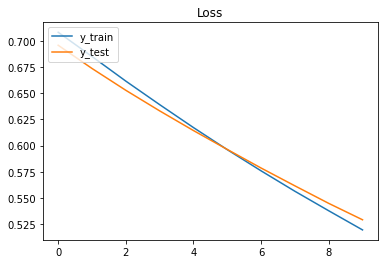

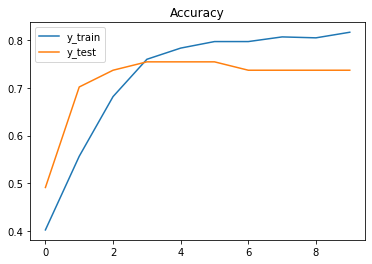

In [892]:
import matplotlib.pyplot as plt
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="y_train")
plt.plot(loss_val_curve, label="y_test")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="y_train")
plt.plot(acc_val_curve, label="y_test")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

# Conclusion

MLPClassifier et DNNClassifier sont tous deux des implémentations du réseau neuronal feed-forward le plus simple. En principe, ils sont donc identiques.

Tensorflow est une bibliothèque d'apprentissage profond. scikit-learn est une bibliothèque d'apprentissage automatique plus traditionnelle.

scikit-learn a une couverture très limitée pour l'apprentissage profond, seulement MLPClassifier et MLRegressor, qui sont les bases des bases. Les développeurs de scikit-learn se concentrent sur un domaine plus traditionnel de l'apprentissage automatique et ont fait le choix délibéré de ne pas trop s'étendre dans le domaine de l'apprentissage profond.

Tensorflow, en revanche, est dédié à l'apprentissage profond. Il permet de composer des modèles d'apprentissage profond très complexes. Et le support du GPU est très important pour l'apprentissage profond, nous avons vraiment besoin de cette vitesse 1000 fois supérieure pour réaliser un travail significatif dans ce domaine.